### Non-Parametric (Historical) Monte-Carlo VaR 

In [6]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf 
import matplotlib.pyplot as plt
from scipy.stats import norm 

### Step 1: extract 10 years historical data

In [105]:
## Future return will based on 5 years historial average P/F return, standard deviation = Strong Assumption
year = 5 
tickers = ['SPY','AAPL','QQQ']
close_price = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = (dt.datetime.now() - dt.timedelta(days=365*year)) , end = dt.datetime.now())
    close_price[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,SPY,AAPL,QQQ
Date,,,
2019-07-05,275.856140,49.275463,185.069977
2019-07-08,274.340271,48.259682,183.771912
2019-07-09,274.682159,48.554047,184.692184
2019-07-10,275.994720,49.034168,186.532715
2019-07-11,276.641693,48.677094,186.397079
...,...,...,...
2024-06-25,544.830017,209.070007,479.380005
2024-06-26,545.510010,213.250000,480.369995
2024-06-27,546.369995,214.100006,481.609985


## Step 2 calculate log return, portfolio return, portfolio standard deviation

In [15]:
daily_return = np.log(close_price/close_price.shift(1)).dropna()
daily_return.mean()

SPY     0.000542
AAPL    0.001158
QQQ     0.000759
dtype: float64

In [23]:
## Assuming future return will depend on the past return
def portfolio_return(weights, daily_return):
    return np.sum((daily_return.mean()*weights))

def portfolio_std(weights, cov_mat):
    variance =  weights.T @ cov_mat @ weights
    return np.sqrt(variance)


In [30]:
weights = np.array([1/len(tickers)]*len(tickers))
cov_mat = daily_return.cov()
portfolio_return = portfolio_return(weights, daily_return)
portfolio_std = portfolio_std(weights, cov_mat)

print(f'daily P/F historical return: {portfolio_return} ($)')
print(f'daily standard deviation of the portfolio: {portfolio_std} ($)')

daily P/F historical return: 0.0008195906373537818 ($)
daily standard deviation of the portfolio: 0.015630165909828 ($)


## Step 3 Monte Carlo Simulation

In [237]:
scenario_return = np.zeros((simulations, int(days) + 1))

# Populate the scenario_return array with simulated returns
for i in range(simulations):
    for day in range(1, int(days) + 1):  # Start from day 1
        z_score = random_score()
        scenario_return[i, day] = portfolio_value * gain_losses(portfolio_return, day, z_score, portfolio_std)

# Check if the shape of the scenario_return array is as expected
if scenario_return.shape != (simulations, int(days) + 1):
    raise ValueError("Revectorise scenario returns")
scenario_return

array([[   0.        , -184.07931055, -431.65791475],
       [   0.        ,  106.84108029,  417.58881692],
       [   0.        ,  -81.28849278, -394.21753311],
       ...,
       [   0.        , -371.88158131,  151.81724523],
       [   0.        ,  172.56276726,  143.89211762],
       [   0.        , -402.03513027, -252.17195744]])

In [248]:
# Again, I assume the future return will based on 5 years historical return and volatility. 
def random_score():
    return np.random.normal(0,1)

scenario_prices = []
simulations = 1000
def gain_losses(portfolio_return, days, z_score, portfolio_std):
    return portfolio_return * days + z_score * portfolio_std * np.sqrt(days)
    
portfolio_value = 10000

days = 3
scenario_return = np.zeros((simulations, int(days)+1))

for i in range(simulations):
    for day in range(1, int(days)+1):
        z_score = random_score()
        scenario_return[i, day] = portfolio_value * gain_losses(portfolio_return, day+1, z_score, portfolio_std)

if scenario_return.shape != (simulations,int(days)+1):
    raise ValueError("Revectorise scenario returns")

latest_scenario_return = scenario_return[:,-1]


## Step 4 Compute VaR with visualisation

In [249]:
confidence_level = 0.99
VaR = np.percentile(latest_scenario_return,  100*(1-confidence_level))
VaR

-748.7511885896532

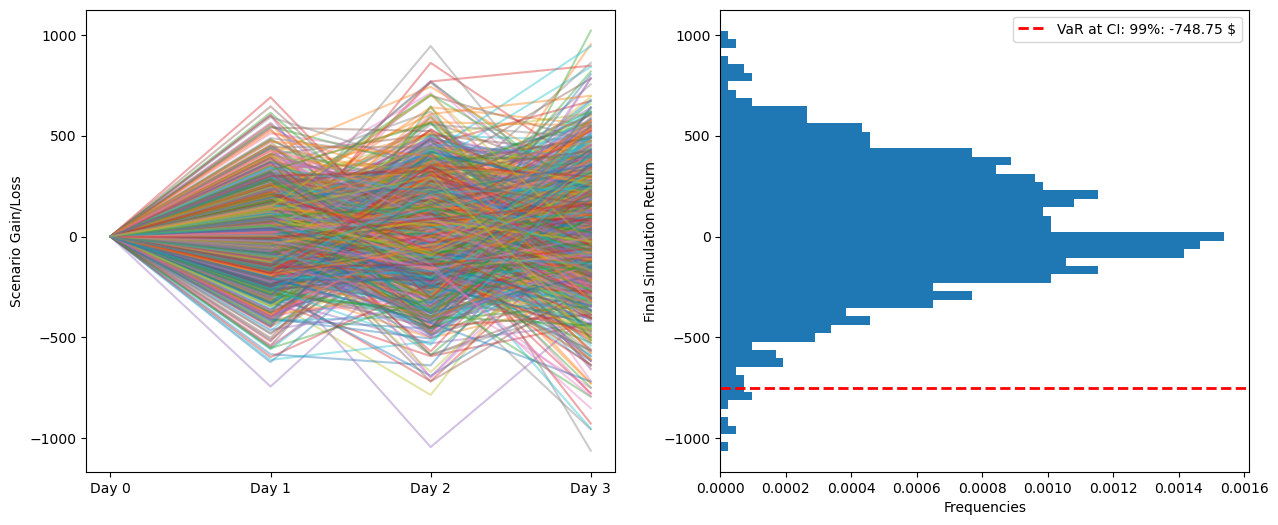

In [253]:
### Plot the results of all 10000 scenarios
fig = plt.figure(figsize=(15, 6))

axes1 = fig.add_subplot(1, 2, 1)
axes2 = fig.add_subplot(1, 2, 2)

N = scenario_return.shape[0]
for i in range(N):
    axes1.plot(scenario_return[i],alpha = 0.4) 
    
xticks = np.arange(int(days)+1)
xtick_labels = [f'Day {i}' for i in range(int(days)+1)]
axes1.set_xticks(xticks)
axes1.set_xticklabels(xtick_labels)
axes1.set_ylabel('Scenario Gain/Loss')

# Plot the histogram on axes2 with the desired parameters
axes2.hist(latest_scenario_return, bins=50, density=True, orientation='horizontal')
axes2.set_xlabel('Frequencies')
axes2.set_ylabel('Final Simulation Return')
axes2.axhline(VaR, linewidth=2, linestyle='dashed', color='r' , label=f'VaR at CI: {confidence_level:.0%}: {VaR:.2f} $')
plt.legend()
